In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn,Row
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.classification import GBTClassifier,LogisticRegression, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer


**environment set up & data import**

In this section includes a function to make sure this notebook is running in databricks environment. I will also define a function to read the csv data file that has been preloaded to databricks.

In [0]:
# Define a function to determine if using databricks. Return true if running in databricks environment, false otherwise
def is_databricks():
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    if db_env != None:
        return True
    else:
        return False

      
#Define a function to read the csv data file. 
#If we are running on databricks, then build the full path file name under databricks enviornment, o.w the data is assuemed to be in the same dir as this notebook.
def read_file(data_file_name):    
    if is_databricks():
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name    
    else:
        full_path_name = data_file_name
    return full_path_name

In [0]:
data= spark.read.csv(read_file('fueleconomyData.csv'), header=True, inferSchema=True)
print(data.toPandas().shape)

(42376, 83)

**Data Preparation**

1. the orinigal dataset contains records for electric vehicles which solely rely or electricity. Therefore I will first remove observations for electric vehicles. 

2. according to data description from fueleconomy.gov, columns such as 'barrelesA08','city08U','cityA08U' etc, are for electric vehicles, therefore I will subset and select only columnns that will be used for analyzing fuel economy

3. process on observations contain NAs and duplicates

In [0]:
#step1:observe fuelType distinct data, and remove the ones that have 'Electricity'
data.select(['fuelType']).distinct().collect()
data_filtered=data.filter(data['fuelType']!='Electricity')
data_filtered.toPandas().shape

Out[4]: (42137, 83)

In [0]:
#step2: select columns needed for model analysis
df=data_filtered.select("barrels08","displ","city08","comb08","highway08",
         "fuelCost08","cylinders","make","model","fuelType","co2TailpipeGpm",
         "trany","VClass","year", "youSaveSpend")
df.toPandas().shape #(42137,15)
#df.describe().show(truncate=False)

Out[5]: (42137, 15)

In [0]:
#step 3: Remove NAs in "cylinders" and "displ"
data1=df.filter((df.displ != "NA") & (df.cylinders !="NA"))
data1.describe().show(truncate=True)
data1.toPandas().shape #(42134, 17)
# only keep unique observations and remove duplicates
vehicle_df_1=data1.distinct()

if vehicle_df_1.count() == vehicle_df_1.drop_duplicates().count():
  print('no duplicates')
print("Unique Records: "+ str(vehicle_df_1.count()))
#uni_df.toPandas().shape  #(41230, 15)

+-------+--------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+----------+------------------+--------------------+------------------+--------------+--------------------+------------------+-------------------+
summary| barrels08| displ| city08| comb08| highway08| fuelCost08| cylinders| make| model| fuelType| co2TailpipeGpm| trany| VClass| year| youSaveSpend|
+-------+--------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+----------+------------------+--------------------+------------------+--------------+--------------------+------------------+-------------------+
 count| 42134| 42134| 42134| 42134| 42134| 42134| 42134| 42134| 42134| 42134| 42134| 42132| 42134| 42134| 42134|
 mean| 17.297937024549224|3.2890254901029996|18.037475672853276|20.32391892533346|24.25727441021503|1807.7633265296436| 5.713271941899653| null|1387.0572916666667| null|466.72853043681914| null| null|2002.0015901647125|-3284.4436796886125|
 stddev| 4.482882048614555| 1.357244096305946| 5.047839930329431|5.316764841724291|5.960719897453495| 517.0364536640435|1.7590817902897269| null|2485.9462075654315| null|119.71863600470921| null| null|11.395304431222302| 2588.8408520973717|
 min|0.060000000000000005| 0.6| 6| 7| 9| 550| 10|AM General| 1-Ton Truck 2WD| CNG| 22.0|Automatic (A1)| Compact Cars| 1984| -23750|
 max| 47.08714285714285| 8.4| 58| 58| 61| 5900| 8| smart| xD|Regular Gas or El...|1269.5714285714287| Manual 7-spd|Vans, Passenger Type| 2021| 3000|
+-------+--------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+----------+------------------+--------------------+------------------+--------------+--------------------+------------------+-------------------+

no duplicates
Unique Records: 41230

# **Regression Models**

1. Data random split by 7:3
2. Linear Regression on Saving/Spending 
3. Random Forest Model on Saving/Spending

In [0]:
# randomly split data into 70% training data, and 30% testing data
[train_set, test_set]= vehicle_df_1.randomSplit([0.7,0.3],seed=0)

**Linear Regression Model on Saving/Spending**
1. Linear Regression Pipeline define
2. Model Evaluation using MSE and Rsquare
3. use elastic net regularization to find the best parameters

In [0]:
# use stringindexer to map columns of labels
catInex=StringIndexer(inputCols=('barrels08','displ','fuelCost08','cylinders',"make","model","fuelType",'trany','VClass','youSaveSpend'),
                      outputCols=("bar_idx","dis_idx",'fc_idx','cyl_idx',"make_idx","model_idx","ft_idx","tran_idx","Vclass_idx",'Save/Spend')).setHandleInvalid('keep')
# use one hot encoding to transform categorical indices to binary vectors
onehot_idx=OneHotEncoder(inputCols=("make_idx","model_idx","ft_idx","tran_idx","Vclass_idx"),outputCols=("makevec",'modelvec','ftvec','tranvec','Vclassvec'))
# use vector assembler to combine all input columnes needed and produce as a single column as a vector
va=feature.VectorAssembler(inputCols=["bar_idx","dis_idx",'fc_idx','cyl_idx',"make_idx","model_idx","ft_idx","tran_idx","Vclass_idx"],outputCol='features')
# standardize input columns
standscaler=feature.StandardScaler(inputCol="features",outputCol="scaledfeatures")
lr=regression.LinearRegression(featuresCol = 'scaledfeatures', labelCol='Save/Spend') 

In [0]:
#create a linear regression pipeline by defining the stages mentioned above and train the model
linear_pipe=Pipeline(stages=[catInex,va,standscaler,lr ])
linear_pipe_model=linear_pipe.fit(train_set)
linear_pred_fitted=linear_pipe_model.transform(test_set)

In [0]:
#Linear regression model evaluation using MSE
evaluator=RegressionEvaluator(labelCol="Save/Spend",predictionCol="prediction",metricName="mse")
mse = evaluator.evaluate(linear_pred_fitted)
# Model Evaluation using R square
r2evaluator=RegressionEvaluator(labelCol="Save/Spend",predictionCol="prediction",metricName="r2")
rsquare=r2evaluator.evaluate(linear_pred_fitted)

print("Linear Model Evalution using MSE: %.3f"% mse,"\n Linear Model Evalution Using R2: %.3f"% rsquare)

Linear Model Evalution using MSE: 1.347 
 Linear Model Evalution Using R2: 0.985

In [0]:
#coefficients of all indepentdent variables used in the linear model
cols_to_scale=['barrels08','displ','fuelCost08','cylinders',"make","model","fuelType",'trany','VClass']
coefficient_linear=linear_pipe_model.stages[-1].coefficients
linear_coeff=pd.DataFrame({'Independent Variables':cols_to_scale,
                              'Coefficient Values':coefficient_linear})
linear_coeff['Coefficient Values'] = linear_coeff['Coefficient Values'].abs()
display(linear_coeff.sort_values("Coefficient Values",ascending=False))

Independent Variables,Coefficient Values
fuelCost08,9.329714943761175
fuelType,0.07119565983605797
cylinders,0.018668528187233527
displ,0.012300759320582179
VClass,0.010824395599076487
model,0.0098481497807247
trany,0.007863639827573652
barrels08,0.006568933061365508
make,0.004509152591631972


In [0]:
import numpy as np
elastic_net_alpha = np.arange(0, 1, 0.5)
elastic_net_lambda = np.arange(.00,.90,.25)
#do grid search using each parameters
grid_search=False

if grid_search:
  paramgrid = ParamGridBuilder()\
            .addGrid(lr.regParam, elastic_net_lambda ) \
            .addGrid(lr.elasticNetParam, elastic_net_alpha) \
            .build()
  crossval = CrossValidator(estimator=linear_pipe,
                                  estimatorParamMaps=paramgrid,
                                  evaluator=r2evaluator,
                                  numFolds = 3,
                                  seed = 0)
  lr_cv = crossval.fit(train_set)
  pass

**Random Forest Model on Save/Spend**
1. Random Forest Pipeline define
2. Model Evaluation uisng MSE and Rsquare
3. Using paramgridbuilder to find the best parameters for the RF model

In [0]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer

In [0]:
# Define stages needed for building random forest model pipeline
ss_rf_va=VectorAssembler(inputCols=["bar_idx","dis_idx",'fc_idx','cyl_idx',"make_idx","model_idx","ft_idx","tran_idx","Vclass_idx"],outputCol='RFfeatures')
ss_rf_featureIndex=VectorIndexer(inputCol='RFfeatures',outputCol='rfindexFeatures')
ss_rf=RandomForestRegressor(featuresCol='rfindexFeatures',numTrees=110,maxBins=4200).setLabelCol('Save/Spend')

In [0]:
#random forest pipeline, train model
rf_pipe=Pipeline(stages=[catInex,ss_rf_va,ss_rf_featureIndex,ss_rf])
rf_pipe_model=rf_pipe.fit(train_set)
rf_pred_fitted=rf_pipe_model.transform(test_set)

In [0]:
#model evaluation using MSE and Rsquare
rf_mse=evaluator.evaluate(rf_pred_fitted)
rf_r2=r2evaluator.evaluate(rf_pred_fitted)
print("Random Forest Model Evalution using MSE: %.3f"% rf_mse,"\n Random Forest Model Evalution Using R2: %.3f"% rf_r2)

Random Forest Model Evalution using MSE: 2.711 
 Random Forest Model Evalution Using R2: 0.969

In [0]:
#importance of independent vehicle features used to predict Save/Spending
import pandas as pd
rf_model = rf_pipe_model.stages[-1]

features_names=['barrel','displacement','fuelcost','cylinders','manufacturer','model','fuel type','transmission','Vehicle Class']
rf_feature_importance=pd.DataFrame(list(zip(features_names,
                                            rf_model.featureImportances.toArray())),
                                   columns=['vehicle features','importance']) \
                                   .sort_values("importance",ascending=False)
display(rf_feature_importance)                                  

vehicle features,importance
fuelcost,0.457937800781426
barrel,0.23003317636752352
model,0.2220474269719734
displacement,0.04320741014268509
fuel type,0.026126066177406884
cylinders,0.008757478694546331
manufacturer,0.00783248098159767
transmission,0.0024288299805160234
Vehicle Class,0.0016293299023251552


In [0]:
# parambuilder grid search to find the best parameter for random forest model
rf_grid_search=False # set to True
if rf_grid_search:
  rf_pipeline = Pipeline(stages=[catInex,ss_rf_va,ss_rf_featureIndex, ss_rf])
  grid = ParamGridBuilder().addGrid(ss_rf.numTrees, [10,50,70,100,110]).addGrid(ss_rf.maxDepth,[10,20]).build()
  rf_evaluator=RegressionEvaluator(labelCol='Save/Spend',predictionCol='prediction',metricName='rmse')
  cross_val=CrossValidator(estimator=rf_pipeline,
                         estimatorParamMaps=grid,
                         evaluator=rf_evaluator,
                         numFolds=3)
  rf_grid_result=cross_val.fit(train_set)
  rmse_rf=rf_grid_result.avgMetrics
  pass

# Unsupervised Models #
 **Principle Component Analysis**
 1. Define Pipeline for PCA analysis
 2. Use explainedVariance attribute to find out the percentage of variance captured
 3. Illustrate in Scree Plot

In [0]:
#building pipeline and build a principal component object with the same number of components as features ie k=9
vec_ass=feature.VectorAssembler(inputCols=["bar_idx","dis_idx",'fc_idx','cyl_idx',"make_idx","model_idx","ft_idx","tran_idx","Vclass_idx"],outputCol="num_features")
standard=feature.StandardScaler(withMean=True,inputCol='num_features',outputCol='zfeatures')
norm = feature.Normalizer(inputCol="zfeatures", outputCol="norm_tfidf", p=2.0)
pca = feature.PCA(k=9, inputCol='zfeatures', outputCol='PCA_scores')

In [0]:
cluster_pipe=Pipeline(stages=[catInex,vec_ass,standard,norm,pca]).fit(train_set)
cluster_model=cluster_pipe.transform(test_set)

In [0]:
#using exlainedVariance attribute to find out the percentage of variance described by each of the principal components, the first component captures 24.29% of the total variance
explained_var = cluster_pipe.stages[-1].explainedVariance
explained_var

Out[20]: DenseVector([0.2429, 0.159, 0.1325, 0.1263, 0.0934, 0.0819, 0.0709, 0.0555, 0.0377])

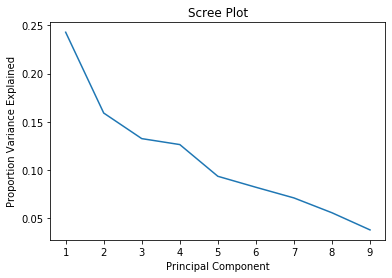

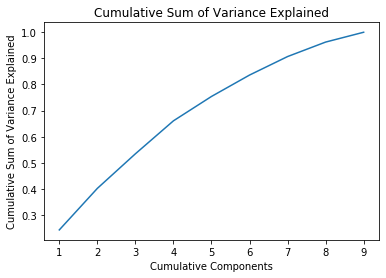

In [0]:
#use scree plot to illustrate the explainedVariance explained in above cell
import numpy as np
plt.figure()
explained_var = cluster_pipe.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

**Recommendation System using PC1 & PC2**
1. first rearrange original dataset and combine 'make' and 'model' columns, so that different vehicle model from same manufacturers can be analyzed distinctly
2. define get_similar_vehicle() to create a recommendation system

In [0]:
#combine 'make' and 'model' columns, into a new column "brand"
from pyspark.sql import Row
from pyspark.sql.functions import  concat
col_list=['make','model']
sample_1=vehicle_df_1
sample_1=sample_1.withColumn('brand',concat(*col_list))
sample_1=sample_1.dropDuplicates(['brand'])

In [0]:
test=sample_1.filter(col('make').contains('Ferrari'))

+------------------+-----+------+------+---------+----------+---------+-------+--------------------+--------+-----------------+---------------+----------------+----+------------+--------------------+
 barrels08|displ|city08|comb08|highway08|fuelCost08|cylinders| make| model|fuelType| co2TailpipeGpm| trany| VClass|year|youSaveSpend| brand|
+------------------+-----+------+------+---------+----------+---------+-------+--------------------+--------+-----------------+---------------+----------------+----+------------+--------------------+
23.543571428571425| 3.2| 11| 14| 17| 2250| 8|Ferrari|3.2 Mondial/Cabri...| Regular|634.7857142857143| Manual 5-spd|Minicompact Cars|1989| -5500|Ferrari3.2 Mondia...|
25.354615384615386| 3.2| 11| 13| 17| 2400| 8|Ferrari| 328 GTS/GTB| Regular|683.6153846153846| Manual 5-spd| Two Seaters|1987| -6250| Ferrari328 GTS/GTB|
 27.4675| 3.6| 10| 12| 15| 3450| 8|Ferrari|360 Modena/Modena F1| Premium|740.5833333333334|Automatic 6-spd| Two Seaters|1999| -11500|Ferrari360 Modena...|
 29.96454545454546| 3.6| 10| 11| 15| 3750| 8|Ferrari|360 Modena/Spider...| Premium|807.9090909090909| Manual 6-spd| Two Seaters|2004| -13000|Ferrari360 Modena...|
23.543571428571425| 4.5| 13| 14| 17| 2950| 8|Ferrari| 458 Italia| Premium| 618.0|Automatic (AM7)| Two Seaters|2015| -9000| Ferrari458 Italia|
23.543571428571425| 4.5| 12| 14| 18| 2950| 8|Ferrari| 458 Italia Spider| Premium|634.7857142857143|Automatic (AM7)| Two Seaters|2012| -9000|Ferrari458 Italia...|
23.543571428571425| 4.5| 13| 14| 17| 2950| 8|Ferrari| 458 Speciale| Premium| 618.0|Automatic (AM7)| Two Seaters|2014| -9000| Ferrari458 Speciale|
19.388823529411766| 3.9| 15| 17| 20| 2450| 8|Ferrari| 488 Pista| Premium| 524.0|Automatic (AM7)| Two Seaters|2019| -6500| Ferrari488 Pista|
36.623333333333335| 5.5| 8| 9| 12| 4600| 12|Ferrari| 550 Maranello| Premium|987.4444444444445| Manual 6-spd| Two Seaters|2000| -17250|Ferrari550 Maranello|
 29.96454545454546| 5.7| 9| 11| 15| 3750| 12|Ferrari|575 M Maranello a...| Premium|807.9090909090909| Manual 6-spd| Two Seaters|2005| -13000|Ferrari575 M Mara...|
 29.96454545454546| 5.9| 10| 11| 14| 3750| 12|Ferrari| 599 GTB| Premium|807.9090909090909| Manual 6-spd| Two Seaters|2007| -13000| Ferrari599 GTB|
 27.4675| 5.9| 11| 12| 15| 3450| 12|Ferrari| 599 GTO| Premium|740.5833333333334|Automatic (AM6)| Two Seaters|2011| -11500| Ferrari599 GTO|
 29.96454545454546| 5.7| 9| 11| 16| 3750| 12|Ferrari| 612 Scaglietti| Premium|807.9090909090909|Automatic 6-spd| Midsize Cars|2007| -13000|Ferrari612 Scagli...|
25.354615384615386| 6.5| 12| 13| 16| 3150| 12|Ferrari| 812 Superfast| Premium| 661.0|Automatic (AM7)| Two Seaters|2019| -10000|Ferrari812 Superfast|
 41.20125| 6.0| 7| 8| 12| 5150| 12|Ferrari| Enzo Ferrari| Premium| 1110.875| Automatic (S6)| Two Seaters|2003| -20000| FerrariEnzo Ferrari|
 27.4675| 6.3| 11| 12| 15| 3450| 12|Ferrari| F12 tdf| Premium| 714.0|Automatic (AM7)| Two Seaters|2016| -11500| FerrariF12 tdf|
 29.96454545454546| 5.9| 9| 11| 13| 3750| 12|Ferrari| F141| Premium|807.9090909090909|Automatic 6-spd| Two Seaters|2006| -13000| FerrariF141|
 29.96454545454546| 3.5| 9| 11| 14| 3750| 8|Ferrari| F355/355 F1| Premium|807.9090909090909| Manual 6-spd| Two Seaters|1999| -13000| FerrariF355/355 F1|
25.354615384615386| 2.9| 11| 13| 16| 3150| 8|Ferrari| F40| Premium|683.6153846153846| Manual 5-spd| Two Seaters|1992| -10000| FerrariF40|
 20.600625| 3.9| 15| 16| 19| 2600| 8|Ferrari| F8 Tributo| Premium| 539.0|Automatic (AM7)| Two Seaters|2020| -7250| FerrariF8 Tributo|
+------------------+-----+------+------+---------+----------+---------+-------+--------------------+--------+-----------------+---------------+----------------+----+------------+--------------------+
only showing top 20 rows

In [0]:
import requests
import numpy as np
from pyspark.sql import types
#1) get_silimar_vehicle(): this function takes two 2 arguments, 1) veh:a string which define the vehicle for which we want to find similar vehicles; 2) num_similar_veh: an integer that defines the total number of similar vehicles which we want to include in the final result. get_silimar_vehicle function would generate a list of strings that include similar vehicles to 'veh', moreover, the list of similar vehicles would be calculated by using function veh_distance().
#2) veh_distance() takes two column vectors and returns the L2 Euclidian distance between them.

def get_silimar_vehicle(veh, num_similar_veh):
  pca_rec = feature.PCA(k=2, inputCol='zfeatures', outputCol='PCA_scores')
  vehicle_pipe=Pipeline(stages=[catInex,vec_ass,standard,norm,pca_rec]).fit(sample_1)
  def veh_distance(c1,c2):
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

  vehicle_dist_udf=fn.udf(veh_distance,types.FloatType())
  spark.sql("SET spark.sql.crossJoin.enabled=TRUE")
  similar_vehicle=vehicle_pipe.transform(sample_1).where(fn.col("brand")==veh).select(fn.col("PCA_scores").alias('vehicle_scores')).join(vehicle_pipe.transform(sample_1)).withColumn('Distance',vehicle_dist_udf('PCA_scores','vehicle_scores')).where('Distance>0').select("brand","Distance").orderBy(fn.asc("Distance")).limit(num_similar_veh).select('brand').rdd.map(lambda x:x[0]).collect()
  return similar_vehicle


recommendation system results

In [0]:
# Use function defined above to find 20 vehicle models that are similar to BMW 228i and FerrariF8
print("20 Vehicles similar to BMW2281 xDrive: \n  ",  get_silimar_vehicle('BMW228i xDrive', 20))

print("20 Vehicles similar to FerrariF8:")
print(get_silimar_vehicle('FerrariF8 Tributo', 20))

20 Vehicles similar to BMW2281 xDrive: 
 ['BMW228i', 'BMW230i Convertible', 'BMW230i xDrive Convertible', 'BMW230i xDrive Coupe', 'BMW428i Convertible', 'BMW430i Convertible', 'BMW530i xDrive', 'BMW228i xDrive Gran Coupe', 'BMW320i xDrive', 'BMW428i Coupe', 'BMW430i Coupe', 'BMW430i Gran Coupe', 'BMW430i xDrive Coupe', 'BMW430i xDrive Gran Coupe', 'Land RoverRange Rover Evoque (286 Hp)', 'Land RoverRange Rover Evoque 286HP', 'Land RoverRange Rover Evoque Cabriolet', 'AcuraTLX 2WD', 'BMW330i xDrive Gran Turismo', 'ChevroletChevette CS']
20 Vehicles similar to FerrariF8:
['FerrariFerrari 348 TB/TS/Spider', 'PorscheCayenne GTS', 'Ferrari328 GTS/GTB', 'ChryslerAspen 4WD', 'SuzukiSwift', 'LincolnAviator 2WD', 'BMW650ci Convertible', 'FerrariMondial T/Cabriolet', 'LincolnAviator 4WD', 'InfinitiQX80 4WD (over 6000 lbs curb weight)', 'InfinitiQX80 4WD', 'Mercedes-Benz560SEC', 'Land RoverRange Rover County LWB', 'DodgeRamcharger 4WD', 'JaguarXJ12', 'JaguarXJS V12 Coupe', 'JaguarXJS V12 Convertible', 'FerrariMondial/Cabriolet', 'SpykerC8 Aileron', 'Saleen PerformanceS281 Family']

In [0]:
bmw_vehicle=get_silimar_vehicle('BMW228i xDrive',30)

norm = feature.Normalizer(inputCol="zfeatures", outputCol="norm_tfidf", p=2.0)
rec_pca = feature.PCA(k=2, inputCol='zfeatures', outputCol='PCA_scores')
vehicle_pipe=Pipeline(stages=[catInex,vec_ass,standard,norm,rec_pca]).fit(sample_1)


bmw_X_Pca= vehicle_pipe.transform(sample_1).\
                           where(fn.col('brand').isin(bmw_vehicle)).\
                           select('brand','PCA_scores')

X_bmw=np.array(bmw_X_Pca.rdd.map(lambda x: x['PCA_scores']).collect())
vehicle_name=np.array(bmw_X_Pca.rdd.map(lambda x: x['brand']).collect())


In [0]:
cadi_vehicle=get_silimar_vehicle('FordLTD',30)

cad_X_Pca= vehicle_pipe.transform(sample_1).\
                           where(fn.col('brand').isin(cadi_vehicle)).\
                           select('brand','PCA_scores')

X_cad=np.array(cad_X_Pca.rdd.map(lambda x: x['PCA_scores']).collect())
cad_vehicle_name=np.array(cad_X_Pca.rdd.map(lambda x: x['brand']).collect())


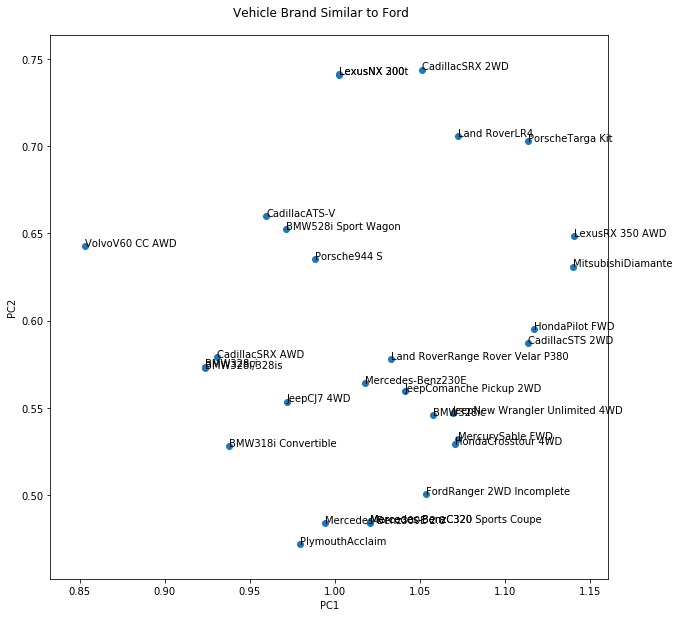

In [0]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(X_cad[:,0], X_cad[:,1])
fig.suptitle("Vehicle Brand Similar to Ford LTD", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for i, txt in enumerate(cad_vehicle_name):
    ax.annotate(txt, (X_cad[i,0], X_cad[i,1]))
plt.show()

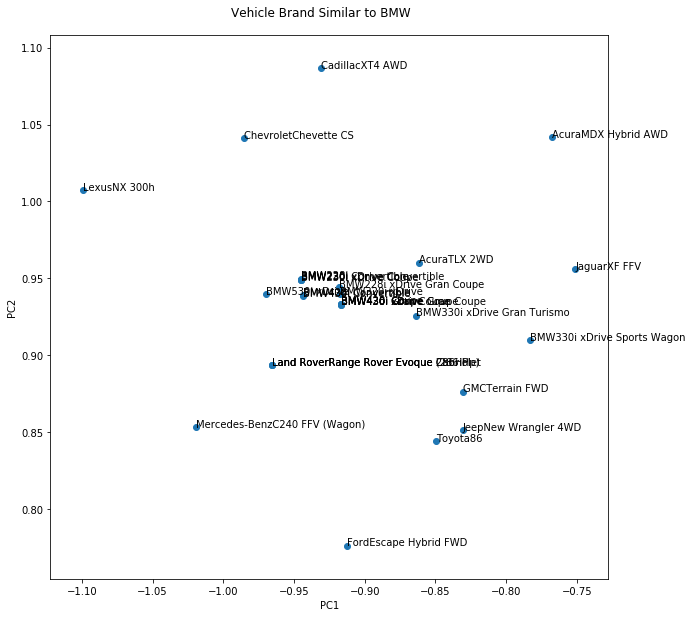

In [0]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(X_bmw[:,0], X_bmw[:,1])
fig.suptitle("Vehicle Brand Similar to BMW 228i", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for i, txt in enumerate(vehicle_name):
    ax.annotate(txt, (X_bmw[i,0], X_bmw[i,1]))
plt.show()

**KMeans Clustering**

In [0]:

km_pipe=Pipeline(stages=[catInex,vec_ass,standard,norm,rec_pca]).fit(vehicle_df_1)

In [0]:
km_model=km_pipe.transform(vehicle_df_1)


In [0]:
km_model.show()

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_coeff=[]
for i in range(3,9):
  kmeans = KMeans(featuresCol="norm_tfidf").setK(i).setSeed(1)
  model = kmeans.fit(km_model)
  predictions = model.transform(km_model)
  evaluator = ClusteringEvaluator(featuresCol="norm_tfidf",predictionCol="prediction")
  silh_score=evaluator.evaluate(predictions)
  silhouette_coeff.append(silh_score)
#7

In [0]:
print(silhouette_coeff)

[0.24428184471976697, 0.2668656283409431, 0.2671390216034771, 0.26955300858492687, 0.25346970389468687, 0.27113788576119174]

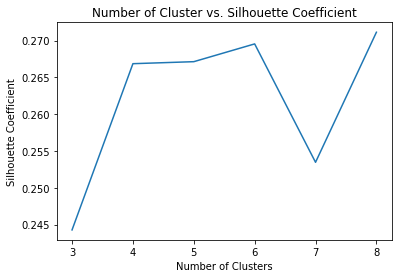

In [0]:
plt.plot(range(3,9), silhouette_coeff)
plt.xticks(range(3, 9))
plt.title("Number of Cluster vs. Silhouette Coefficient")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [0]:
X = np.array(km_model.select('PCA_scores').rdd.map(lambda x: x['PCA_scores']).collect())

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

km_pipe=Pipeline(stages=[catInex,vec_ass,standard,norm,rec_pca]).fit(sample_1)
cluster_plot_model=km_pipe.transform(sample_1)


kmeans = KMeans(featuresCol="norm_tfidf",k=7,seed=1)
kmeans_model = kmeans.fit(cluster_plot_model)
kmeans_predictions = kmeans_model.transform(cluster_plot_model)
evaluator = ClusteringEvaluator(featuresCol="norm_tfidf",predictionCol="prediction")
kmeans_label=kmeans_predictions.select('prediction')


In [0]:
manufacturer = np.array(cluster_plot_model.select('brand').rdd.map(lambda x: x['brand']).collect())
X_2 = np.array(cluster_plot_model.select('PCA_scores').rdd.map(lambda x: x['PCA_scores']).collect())
km_label=np.array(kmeans_predictions.select('prediction').rdd.map(lambda x:x['prediction']).collect())

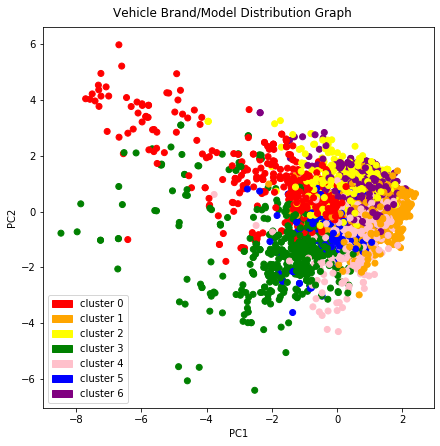

In [0]:
color_map = {0:"red",1:"orange",2:"yellow",3:"green",4:"pink",5:"blue",6:"purple"}
label_color = [color_map[l] for l in km_label]

fig, ax = plt.subplots()
fig.set_figheight(7) 
fig.set_figwidth(7)
ax.scatter(X_2[:,0], X_2[:,1],c=label_color,cmap=plt.cm.Paired)
fig.suptitle("Vehicle Brand/Model Distribution Graph", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='cluster 0')
oran=mpatches.Patch(color='orange', label='cluster 1')
yello=mpatches.Patch(color='yellow', label='cluster 2')
green=mpatches.Patch(color='green', label='cluster 3')
pink=mpatches.Patch(color='pink', label='cluster 4')
blue=mpatches.Patch(color='blue', label='cluster 5')
pur=mpatches.Patch(color='purple', label='cluster 6')
plt.legend(handles=[red_patch,oran,yello,green,pink,blue,pur],loc=3)


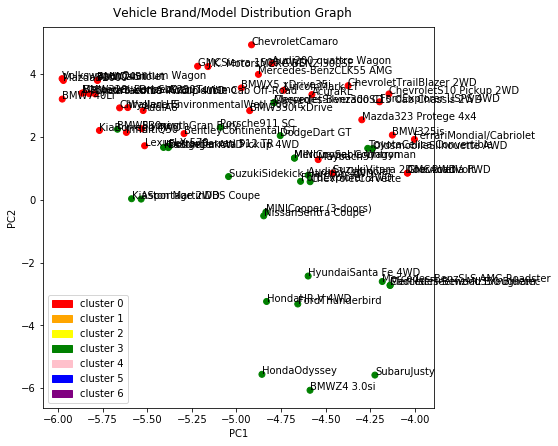

In [0]:
color_map = {0:"red",1:"orange",2:"yellow",3:"green",4:"pink",5:"blue",6:"purple"}
label_color = [color_map[l] for l in km_label]

fig, ax = plt.subplots()
fig.set_figheight(7) 
fig.set_figwidth(7)
ax.scatter(X_2[:,0], X_2[:,1],c=label_color,cmap=plt.cm.Paired)
fig.suptitle("Vehicle Brand/Model Distribution Graph", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")


for i, txt in enumerate(manufacturer):
    ax.annotate(txt, (X_2[i,0], X_2[i,1]))
plt.legend(handles=[red_patch,oran,yello,green,pink,blue,pur],loc=3)
plt.show()

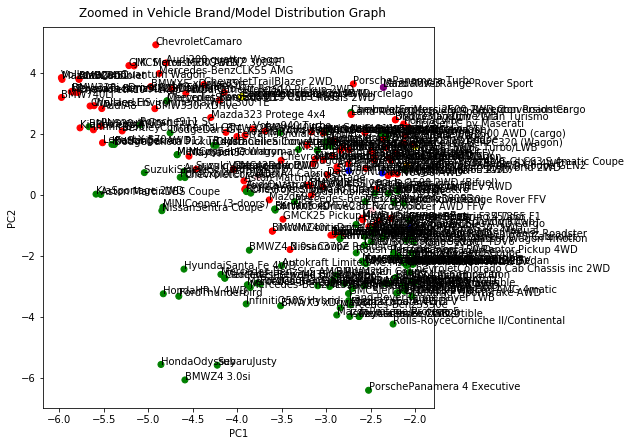

In [0]:
idx = (X_2[:, 0]>-6)&(X_2[:, 0]<-2)
X_2 = X_2[idx]
manufacturer = manufacturer[idx]
km_label=km_label[idx]

color_map = {0:"red",1:"orange",2:"yellow",3:"green",4:"pink",5:"blue",6:"purple"}
label_color = [color_map[l] for l in km_label]

fig, ax = plt.subplots()
fig.set_figheight(7) 
fig.set_figwidth(7)
ax.scatter(X_2[:,0], X_2[:,1],c=label_color,cmap=plt.cm.Paired)
fig.suptitle("Zoomed in Vehicle Brand/Model Distribution Graph", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")


for i, txt in enumerate(manufacturer):
    ax.annotate(txt, (X_2[i,0], X_2[i,1]))
plt.show()

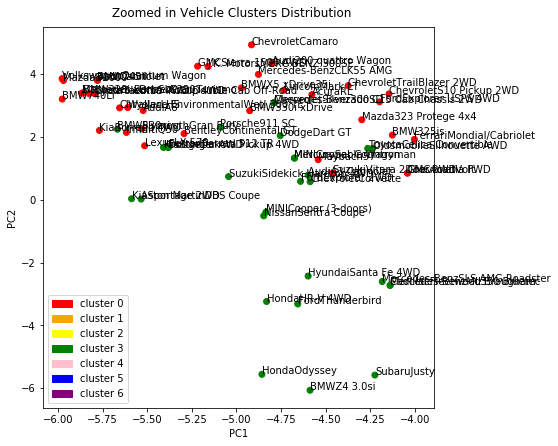

In [0]:
idx = (X_2[:, 0]>-6)&(X_2[:, 0]<-4)
X_2 = X_2[idx]
manufacturer = manufacturer[idx]
km_label=km_label[idx]

color_map = {0:"red",1:"orange",2:"yellow",3:"green",4:"pink",5:"blue",6:"purple"}
label_color = [color_map[l] for l in km_label]

fig, ax = plt.subplots()
fig.set_figheight(7) 
fig.set_figwidth(7)
ax.scatter(X_2[:,0], X_2[:,1],c=label_color,cmap=plt.cm.Paired)
fig.suptitle("Zoomed in Vehicle Clusters Distribution", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")


for i, txt in enumerate(manufacturer):
    ax.annotate(txt, (X_2[i,0], X_2[i,1]))
plt.legend(handles=[red_patch,oran,yello,green,pink,blue,pur],loc=3)
plt.show()